# XGBoost Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

import xgboost as xgb
root = '../instacart_data_files/'
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score


In [2]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()


,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,41,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [3]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [4]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4315.823656082153  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1163.8177070617676  MB
This is  26.96629426509668 % of the initial size


In [5]:
df['order_diff'] = df['order_number'] - df['last_ordered_in']
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)


In [6]:
df.shape


(8474661, 68)

In [7]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [8]:
X = df[x_cols]
y = df[label]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [10]:
y_train.value_counts()


reordered
0.0    5734377
1.0     621618
Name: count, dtype: int64

In [11]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])


10.0

In [12]:
y_test.value_counts()


reordered
0.0    1911460
1.0     207206
Name: count, dtype: int64

## XGBoost Model

In [13]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [14]:
xgb_params = {
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "eta"              :0.1,
    "max_depth"        :6,
    "min_child_weight" :10,
    "gamma"            :0.70,
    "subsample"        :0.76,
    "colsample_bytree" :0.95,
    "alpha"            :2e-05,
    "scale_pos_weight" :10,
    "lambda"           :10
}


In [15]:
watchlist= [(D_train, "train")]
model = xgb.train(params=xgb_params, dtrain=D_train, num_boost_round = 80, evals = watchlist, verbose_eval = 10)

[0]	train-logloss:0.66552
[10]	train-logloss:0.55430
[20]	train-logloss:0.53353
[30]	train-logloss:0.52802
[40]	train-logloss:0.52548
[50]	train-logloss:0.52401
[60]	train-logloss:0.52296
[70]	train-logloss:0.52229
[79]	train-logloss:0.52163


In [16]:
probability = model.predict(D_test)


In [17]:
predictions = [1 if i > 0.5 else 0 for i in probability]



 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.24      0.77      0.37    207206

    accuracy                           0.74   2118666
   macro avg       0.60      0.75      0.60   2118666
weighted avg       0.90      0.74      0.79   2118666

Accuracy   Score :  0.7412367027176535
F1 Score:  0.36850210851388077
Area under curve :  0.8349883258261891 



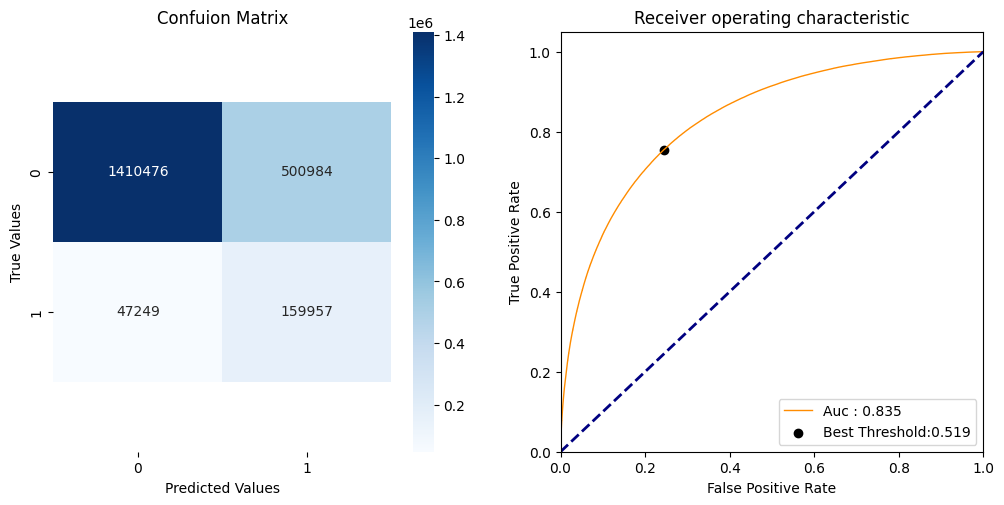

In [18]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()


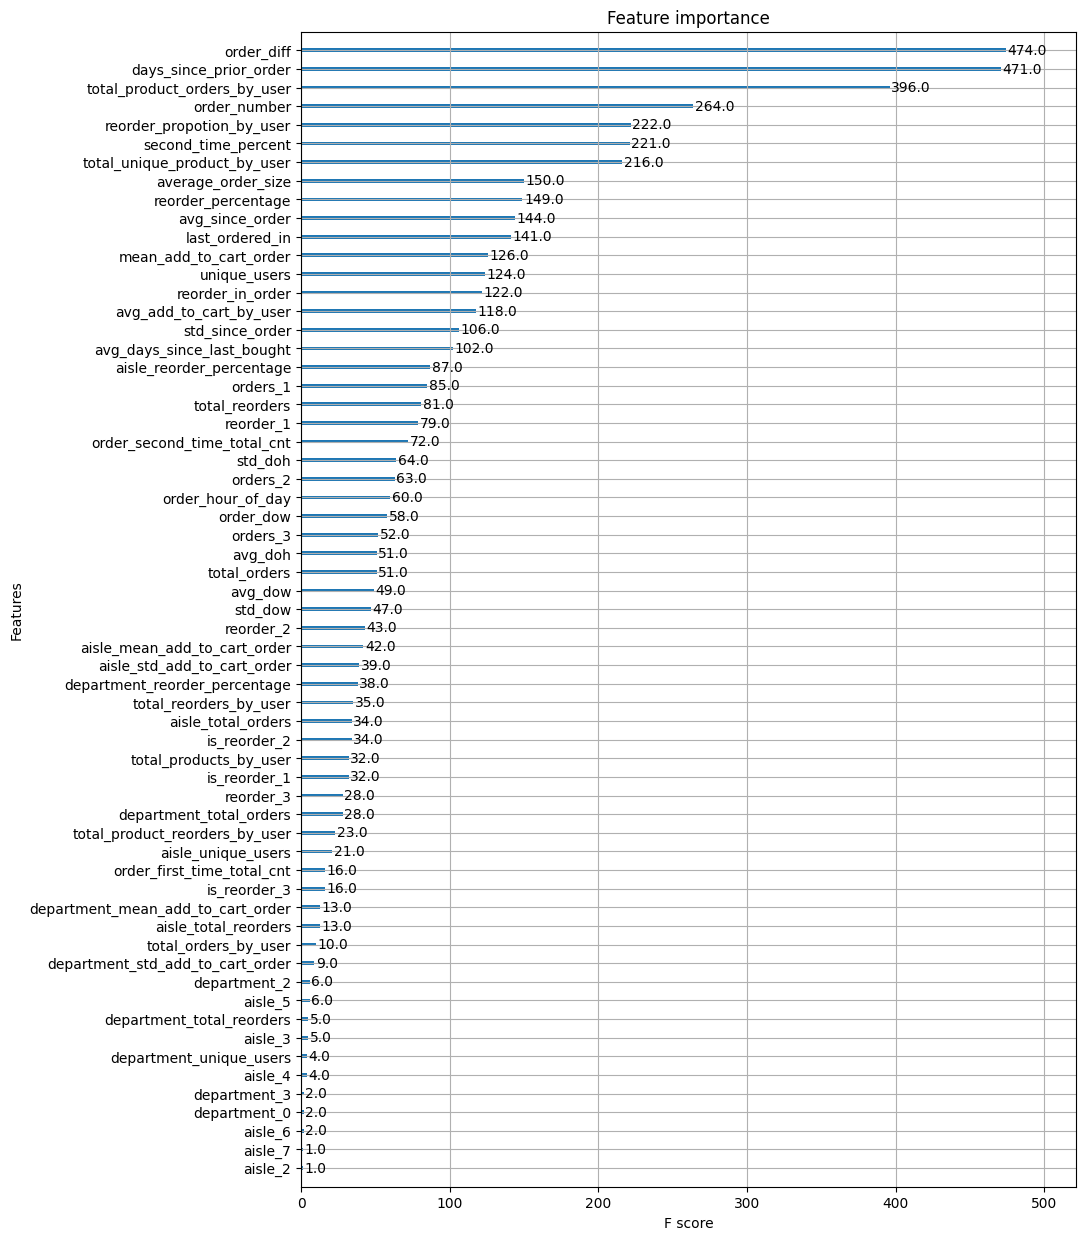

In [19]:
fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, ax = ax)
fig.savefig('XGBoost Feature Importance Plot.png')
